In [6]:
from tensorflow.keras.models import load_model
model = load_model("../Modelos/Etapa2/densenet121_etapa2_birads_3-5_gradcam.keras", compile=False)

2026-01-25 18:47:35.490698: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2026-01-25 18:47:35.491109: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2026-01-25 18:47:35.491115: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2026-01-25 18:47:35.491136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-25 18:47:35.491296: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

/opt/miniconda3/envs/mamografia/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# Función GRAD-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, class_index=None):
    # Modelo que devuelve activaciones + predicción
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        
        class_channel = predictions[:, class_index]

    # Gradientes
    grads = tape.gradient(class_channel, conv_outputs)

    # Promedio global de gradientes
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Ponderar mapas de activación
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # ReLU + normalización
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy()


In [3]:
from tensorflow.keras.applications.densenet import preprocess_input

def load_image(img_path, img_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img_array = np.expand_dims(img, axis=0)
    img_array = preprocess_input(img_array)
    return img, img_array


In [8]:
img_birads4_wrong_path = "/Users/claracelestechavezcotrina/Downloads/DATA_TESIS/dataset_etapa2/test/birads_4/BIRADS_4_39.png"

img, img_array = load_image(img_birads4_wrong_path)

heatmap = make_gradcam_heatmap(
    {"input_layer": img_array},
    model,
    last_conv_layer_name="conv5_block16_concat",
    class_index=1  
)

In [4]:
# Mapa de calor
def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * alpha + img

    plt.figure(figsize=(6,6))
    plt.imshow(superimposed_img.astype("uint8"))
    plt.axis("off")
    plt.show()

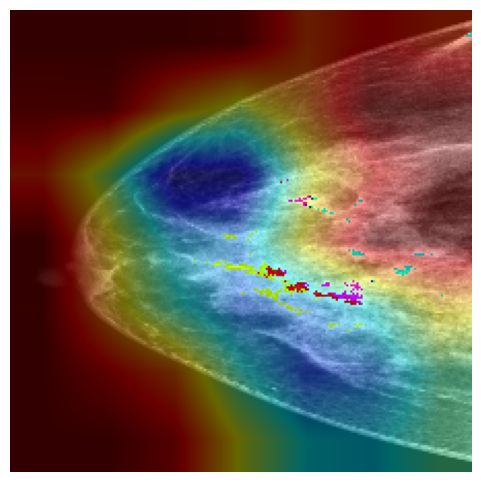

In [9]:
display_gradcam(img, heatmap)

In [13]:
img_birads4_corret_path = "/Users/claracelestechavezcotrina/Downloads/DATA_TESIS/dataset_etapa2/test/birads_4/BIRADS_4_35.png"

img1, img_array1 = load_image(img_birads4_corret_path)

heatmap1 = make_gradcam_heatmap(
    {"input_layer": img_array1},
    model,
    last_conv_layer_name="conv5_block16_concat",
    class_index=1  
)

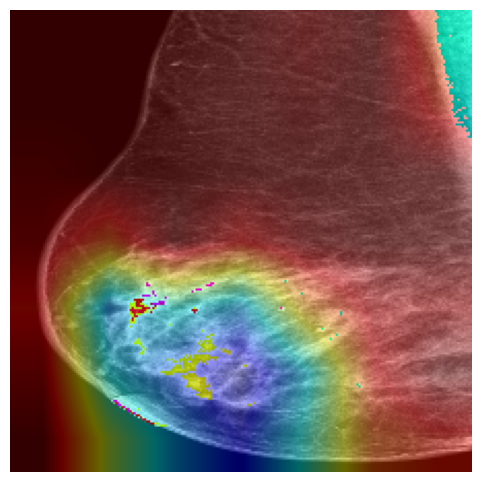

In [14]:
display_gradcam(img1, heatmap1)